# Project - Cdiscount Image Classification



# Data ingestion
The primary training set is a 57GB bson file, having ~15 Million images (180x180 images in Base64 format) of ~7.06 Million products. We have imported the dataset into a MongoDB instance on a VPS, so we were able to query among the records.
We have chosen 100 categories, which overally consist of ~246K images of ~110K products.


## Dataset preparation

First we need to ensure that the "gdown" library is installed and accessible in the environment and download the train_medium data from Google Drive,

In [1]:
! pip install gdown && gdown --id 1F6Xf4yiYxeFEN6qhrL3YBNs0Vhx0bXJ1

Downloading...
From: https://drive.google.com/uc?id=1F6Xf4yiYxeFEN6qhrL3YBNs0Vhx0bXJ1
To: /content/train_shuffled_100cat.csv
1.62GB [00:09, 178MB/s]


In [2]:
%matplotlib inline
import tensorflow as tf
import tensorflow_datasets as tfds # tensorflow datasets - pip install tensorflow-datasets
import numpy as np
import glob
import matplotlib.pyplot as plt
from skimage import transform # pip install scikit-image

ModuleNotFoundError: No module named 'tensorflow_datasets'

## Note for the team
Since the original dataset is pretty large, I've created a subset file containing ~250K photos in 100 categories, but it is still so large that it may not fit into the memory, so I've used the below parameters to load a fitable subset accordingly, please read the comments of each variable careflully, and do not change the loading code please, just set the values of the parameters.

In [2]:
import pandas as pd

import base64
from PIL import Image
import base64
import io
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

Run the cell below if you have a gpu that you want to use

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices):
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 1. Load your data

In [4]:
CONVERT_TO_NP_ARRAY= False   # Wether convert the Base64 string to (180,180,3) arrays or keep the Base64 string.

REPLACE_BASE64_SPECIAL_CHARS = True # If you have the base64 decoding layer in your model, 
                                    # you need to set this to True to replace the two special characters in Base64 that is incompatible with tf image reader

LOADING_MODE = "all" 
                             # num_records: Loads the first NUM_RECORDS in the dataset and calculates NUM_CATEGORIES dynamically
                             # num_categories: Loads first NUM_CATEGORIES and calculates NUM_RECORDS dynamically
                             # all: Loads all the 250K images, ignores all parameters below
                            
    
NUM_RECORDS = 3000           # Only used when the mode is set to num_records
NUM_CATEGORIES = 100           # Only used when the mode is set to num_category
MAX_RECORDS_PER_CATEGORY = 700 # if not zero, will ensure that there is no more per category in the dataframe, won't work when mode is set to all

In [5]:
def get_array_from_base64(img, shape=(180,180,3)):
    print(img)
    return np.array(
        Image.open(
            io.BytesIO(
                base64.b64decode(
                    img.replace('_', '/').replace('-', '+') if REPLACE_BASE64_SPECIAL_CHARS else img
                )
            )
        )
    ).reshape(shape)


In [6]:
FILE_NAME= "../train_shuffled_100cat.csv"
header = 3

df = pd.read_csv(FILE_NAME, header=3, nrows=0)

if LOADING_MODE == "all":
    df = pd.read_csv(FILE_NAME, header=header)

if LOADING_MODE == "num_records":
    reader = pd.read_csv(FILE_NAME, header=header, chunksize=min(NUM_RECORDS, 100))
    for chunk in reader:
        df = df.append(chunk, ignore_index=True)
        if MAX_RECORDS_PER_CATEGORY:
            for cat in df["category_id"].unique():
                if len(df[df["category_id"] == cat]) > MAX_RECORDS_PER_CATEGORY:
                    removed_rows = df[df["category_id"] == cat][MAX_RECORDS_PER_CATEGORY:]
                    df = df.drop(removed_rows.index)
        if df.shape[0]>=NUM_RECORDS:
            df = df.head(NUM_RECORDS)
            break
    
elif LOADING_MODE == "num_categories": 
    reader = pd.read_csv(FILE_NAME, header=header, chunksize=100)
    for chunk in reader:
        df = df.append(chunk, ignore_index=True)
        if df["category_id"].nunique() > NUM_CATEGORIES:
            break
    if MAX_RECORDS_PER_CATEGORY:
        for cat in df["category_id"].unique():
            if len(df[df["category_id"] == cat]) > MAX_RECORDS_PER_CATEGORY:
                removed_rows = df[df["category_id"] == cat][MAX_RECORDS_PER_CATEGORY:]
                df = df.drop(removed_rows.index)

    cat_removed = df["category_id"].unique()[NUM_CATEGORIES:]
    df = df.loc[~df['category_id'].isin(cat_removed)]
    NUM_RECORDS= df.shape[0]

if CONVERT_TO_NP_ARRAY:        
    df["image"] = df["image"].apply(
                    lambda x: get_array_from_base64(x)
                )
if REPLACE_BASE64_SPECIAL_CHARS:
    df["image"] = df["image"].apply(
                    lambda x: x.replace('/', '_').replace('+', '-')
                )
    
NUM_CATEGORIES = df['category_id'].nunique()

categories = df['category_id'].unique()
categories.sort()
category_id_map = {k: v for v, k in enumerate(categories)}
df["class"] = df["category_id"].apply(lambda x: category_id_map[x])

print("Num records:", NUM_RECORDS)
print("Num categories:", NUM_CATEGORIES)
print("Training df shape:", df.shape)
print("Mem used by images:", int(sum(df["image"].apply(lambda x: x.nbytes if type(x)!=str else len(x))/10 ** 6)), "MB")
# print(len(df.at[0, "image"]))

Num records: 3000
Num categories: 99
Training df shape: (246261, 4)
Mem used by images: 1613 MB


In [22]:
df = df.sample(frac=1,random_state = 100)
df.reset_index(drop=True, inplace=True)


In [23]:
X_dev = np.stack(df["image"]) if CONVERT_TO_NP_ARRAY else np.array(df["image"])
Y_dev = np.array(df["class"])
print(X_dev.shape,Y_dev.shape, Y_dev[-10:])


(246261,) (246261,) [22 50 60 27 58 91  9 44 57 60]


## 2. Explore your data 

Showing 10 samples from dev set

In [24]:
plt.figure(figsize=(12, 6), dpi=1000)
indexes = np.arange(len(X_dev))
np.random.shuffle(indexes)
if CONVERT_TO_NP_ARRAY:
    for idx in range(10):
      plt.subplot(2, 5, idx + 1)
      plt.imshow(X_dev[indexes[idx]])
    plt.show()

<Figure size 12000x6000 with 0 Axes>

#Splitting dev set into train/val set

In [25]:
num_train = int(len(X_dev) * .75) #= splitting point of train/val set
num_val = int(len(X_dev) * .2)
num_test = len(X_dev) - num_train - num_val

X_train = X_dev[indexes[:num_train]]
Y_train = Y_dev[indexes[:num_train]]

X_val = X_dev[indexes[num_train:-num_test]]
Y_val = Y_dev[indexes[num_train:-num_test]]

X_test = X_dev[indexes[-num_test:]]
Y_test = Y_dev[indexes[-num_test:]]

print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)

X_train: (184695,)
X_val: (49252,)
X_test: (12314,)


## 3. Represent your labels using one hot encoding

In [12]:
# Y_train_oh = tf.keras.utils.to_categorical(Y_train, num_classes = NUM_CATEGORIES)
# Y_val_oh = tf.keras.utils.to_categorical(Y_val, num_classes = NUM_CATEGORIES)
# Y_test_oh = tf.keras.utils.to_categorical(Y_test, num_classes = NUM_CATEGORIES)


# print("Y_train",  Y_train[:3])
# print("Y_train_oh:",  Y_train_oh[:3])


# print("TRAIN:", X_train.shape, Y_train.shape, Y_train_oh.shape)
# print("VAL:", X_val.shape, Y_val.shape, Y_val_oh.shape)
# print("TEST:", X_test.shape, Y_test.shape, Y_test_oh.shape)

In [4]:
DATA_ROOT="../data-100cat/"
seed = 909 # (IMPORTANT) to input image and corresponding target with same augmentation parameter.

gen_params = {"rescale":1.0/255,"featurewise_center":False,"samplewise_center":False,"featurewise_std_normalization":False,\
              "samplewise_std_normalization":False,"zca_whitening":False,"rotation_range":20,"width_shift_range":0.1,"height_shift_range":0.1,\
              "shear_range":0.2, "zoom_range":0.1,"horizontal_flip":True,"fill_mode":'constant',\
               "cval": 0}

train_image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params) 

train_image_generator = train_image_datagen.flow_from_directory(DATA_ROOT+"train/",
                                                    class_mode="categorical",  classes=[str(i) for i in range(99)], target_size=(180, 180), batch_size = 16,seed=seed,shuffle = True)

train_image_datagen_non_augmented = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) 

train_image_generator_non_augmented = train_image_datagen_non_augmented.flow_from_directory(DATA_ROOT+"train/",
                                                    class_mode="categorical",  classes=[str(i) for i in range(99)], target_size=(180, 180), batch_size = 16,seed=seed,shuffle = True)


val_image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) 

val_image_generator = val_image_datagen.flow_from_directory(DATA_ROOT+"val/",
                                                     class_mode="categorical",  classes=[str(i) for i in range(99)],batch_size = 16,seed=seed, target_size=(180, 180),color_mode='rgb',shuffle = True)

test_image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) 

test_image_generator = val_image_datagen.flow_from_directory(DATA_ROOT+"test/",
                                                     class_mode="categorical", classes=[str(i) for i in range(99)],batch_size = 16,seed=seed, target_size=(180, 180),color_mode='rgb')


Found 184695 images belonging to 99 classes.
Found 184695 images belonging to 99 classes.
Found 49252 images belonging to 99 classes.
Found 12314 images belonging to 99 classes.


## 4. Data scaling and Data augmentation

### Preprocess_and_decode:
It is a function which applies to each image input to the model, it first decodes the JPEG base64 encoded image to a tensor, then it scales it based on the sample's min, max, mean and std.
Since we are normalizing our data per sample, our normalization is row-wise and a column-wise normalization is not yet an option. We can do this by preprocessing our dataset by batching it if that seemed necessary. 

In [11]:
def preprocess_and_decode(img_str, new_shape=(180,180), scaling_mode = 2 ): #scaling_mode= 0: disabled, 1: min-max normalization, 2: standardization
    img = tf.io.decode_base64(img_str)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, new_shape, method=tf.image.ResizeMethod.BILINEAR)
   
    if scaling_mode == 1: 
      img_min = tf.math.reduce_min(img, axis=None, keepdims=False, name=None)
      img_max = tf.math.reduce_max(img, axis=None, keepdims=False, name=None)
      img = ( img - img_min ) / (img_max - img_min)
      
    elif scaling_mode == 2:
      img_mean = tf.math.reduce_mean(img, axis=None, keepdims=False, name=None)
      img_std = tf.math.reduce_std(img, axis=None, keepdims=False, name=None)
      img = ( img - img_mean ) / img_std
      
    return img


### About data augmentation
Since our dataset consist of 2-4 image per product, and we have over 2K images per category, data augmentation seems unnecessary.
I still have not found a way to do data augmentation on Base64 strings(remember I moved to Base64-> tensor decoding inside the model itself to enable us to do batch training on the whole dataset), but if we come to a need for it, there is definitly a way to do that!


## 4. Define your callbacks (save your model, patience, etc.)

In [5]:
model_name = "vgg_project_after_finetuning_withoutaug_all_amin.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%4 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

## 6. Transfer Learning

6.1 Choose and load your pretrained model without the top (i.e., the prediction part, usually the fully connected layers)

6.2. Freeze the layers (i.e., make them non-trainable) of your pretrained model

In [6]:
# Dimensions we will resize the images
img_height = 180
img_width = 180
k = 99
# input64 = tf.keras.layers.Input(shape=(1,), dtype="string")
# img_tensor = tf.keras.layers.Lambda(
#     lambda img: tf.map_fn(lambda im: preprocess_and_decode(im[0]), img, dtype="float32"))(input64)
input_layer = tf.keras.layers.Input(shape=(img_width, img_height, 3), dtype="float32")
base_model = tf.keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False) 
base_model.trainable = False

6.3. Add a top (i.e., the prediction layers)

In [7]:
# input_image = tf.keras.Input(shape=(img_height, img_width, 3))
x1 = base_model(input_layer, training=False)
x2 = tf.keras.layers.Flatten()(x1)
out = tf.keras.layers.Dense(k,activation = 'softmax')(x2) # 99 categories
# out = tf.keras.layers.Dense(len(class_names),activation = 'softmax')(x2)
model = tf.keras.Model(inputs = input_layer, outputs =out)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 12800)             0         
_________________________________________________________________
dense (Dense)                (None, 99)                1267299   
Total params: 15,981,987
Trainable params: 1,267,299
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:

model.fit(train_image_generator_non_augmented,epochs = 20, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(val_image_generator))

Epoch 1/20


Testing 

In [21]:
model.load_weights(model_name)
print("LOADED")
metrics = model.evaluate(X_test,Y_test)

LOADED
385/385 [==============================] - 32s 82ms/step - loss: 0.2325 - accuracy: 0.9453


Fine tunning

In [20]:
base_model = tf.keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False) 
base_model.trainable = True
input64 = tf.keras.layers.Input(shape=(1,), dtype="string")
img_tensor = tf.keras.layers.Lambda(
    lambda img: tf.map_fn(lambda im: preprocess_and_decode(im[0]), img, dtype="float32"))(input64)
# input_image = tf.keras.Input(shape=(img_height, img_width, 3))
x1 = base_model(img_tensor, training=True)
x2 = tf.keras.layers.Flatten()(x1)
out = tf.keras.layers.Dense(k,activation = 'softmax')(x2)
model = tf.keras.Model(input64, out)
print(model.summary())


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 180, 180, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 99)                1267299   
Total params: 15,981,987
Trainable params: 15,981,987
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-6),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.load_weights(model_name)
model.fit(X_train, Y_train,batch_size = 32, epochs = 7, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(X_val, Y_val))

Epoch 1/7
5772/5772 [==============================] - 1831s 317ms/step - loss: 2.9883 - accuracy: 0.2642 - val_loss: nan - val_accuracy: 0.1059
Epoch 2/7
5772/5772 [==============================] - 1802s 312ms/step - loss: 3.4283 - accuracy: 0.1356 - val_loss: nan - val_accuracy: 0.1372
Epoch 3/7
5772/5772 [==============================] - 1800s 312ms/step - loss: 3.4193 - accuracy: 0.1371 - val_loss: nan - val_accuracy: 0.1372
Epoch 4/7
5772/5772 [==============================] - 1796s 311ms/step - loss: 3.4226 - accuracy: 0.1377 - val_loss: nan - val_accuracy: 0.1372
Epoch 5/7
5772/5772 [==============================] - 1791s 310ms/step - loss: 3.4152 - accuracy: 0.1367 - val_loss: nan - val_accuracy: 0.1372
Epoch 6/7
5772/5772 [==============================] - 1790s 310ms/step - loss: 3.4197 - accuracy: 0.1391 - val_loss: nan - val_accuracy: 0.1372
Epoch 7/7
5772/5772 [==============================] - 1793s 311ms/step - loss: 3.4197 - accuracy: 0.1383 - val_loss: nan - val_ac

## 8. Test your model

In [26]:
model.load_weights(model_name)
metrics = model.evaluate(X_test,Y_test)

385/385 [==============================] - 33s 86ms/step - loss: 0.2245 - accuracy: 0.9481


AttributeError: ignored

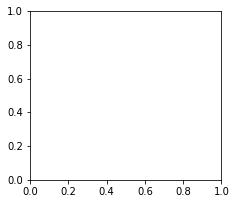

In [24]:
# Ypred = model.predict(X_test).argmax(axis = 1)
# wrong_indexes = np.where(Ypred != Y_test)[0]

# # Disaplying some samples from the development set
# sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 30, replace = False)
# plt.figure(figsize = (24,18))
# for (ii,jj) in enumerate(sample_indexes):
#     plt.subplot(5,6,ii+1)
#     aux = X_test[wrong_indexes[jj]]
#     aux = (aux - aux.min())/(aux.max() - aux.min())
#     plt.imshow(aux, cmap = "gray")
#     plt.title("Label: %d, predicted: %d" %(Y_test[wrong_indexes[jj]],Ypred[wrong_indexes[jj]]))
# plt.show()